### Predict whether or not a school will close based on school characteristics
I use Bernoulli Naive Bayes and various tree-ensemble algorithms (bagged decision trees, random forest, and extra trees) to build a model to predict school closure. Given the class imbalance (only ~6% of schools closed), I use precision-recall tradeoff rather than overall accuracy to asess classifier performance.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#### Write Functions to Clean & Upsample/ Downsample Data, and Evaluate Classifier Performance in terms of Precision-Recall Tradeoff

In [3]:
"""
Function to impute missing data in a dataframe via means imputation
df = Input DF, with missing values
returns: new DF, with means-imputed data
"""
def means_impute(df):
    imputed=Imputer().fit_transform(df[df.columns])
    new_df=pd.DataFrame(imputed, columns=[df.columns])
    
    return new_df


"""
Function to delete any records with missing data (casewise deletion)
df = Input DF, with missing values
returns: new DF, with records with missing data deleted
"""
def casewise_delete(df):
    new_df=df.copy()
    
    for col in df.columns:
        new_df=new_df[new_df[col].notnull()]
        
    return new_df

"""
Function to upsample or downsample input data to balance label classes
df = input (unbalanced) DF
r = majority : minority label class ratio to allow in output dataframe (e.g. R=1 creates a data frame with 1:1 maj:min) 
upsample = Whether to upsample minority class (if True) or downsample majority class (if False) to acheive balanced classes
features = Model features (list of variables)
label = Model label (variable name)
returns: new DF, with balanced label classes
"""
def sampler(df, r, upsample, features, label):
    nlabel = df[label].value_counts()[1]
    nsamp = int(round(nlabel*r))
    
    if upsample==True:
        df_1 = df[df[label]==1].sample(n=nsamp, replace=True).copy()
        df_0 = df[df[label]==0].sample(n=nsamp, replace=True).copy()
    else:
        df_1 = df[df[label]==1].copy()
        df_0 = df[df[label]==0].sample(n=nsamp).copy()
        
    return pd.concat([df_1, df_0], axis=0)

"""
Function to plot the precision-recall tradeoff of various classification algoritms (no class balancing)
classname = Name of algorithm used (as string)
classifier = SK-Learn Classification algorithm
features = Model featuers (list of variable names)
label = Model label (variable name)
return: precision-recall curve for input classifier
"""
def plot_PR_curve_noadj(classname, classifier, features, label):
    train_X=train[features]
    train_y=train[label]
    
    test_X=test[features]
    test_y=test[label]
    
    model=classifier.fit(train_X, train_y)
    
    pr1 = [x[1] for x in model.predict_proba(test_X)]
    #print classname, np.min(pr1), np.median(pr1), np.max(pr1)
    
    prec, recall, t = precision_recall_curve(test_y, pr1)
    plt.plot(prec, recall, label=classname)
    
"""
Function to plot the precision-recall tradeoff of various classification algoritms (with class balancing)
classname = Name of algorithm used (as string)
classifier = SK-Learn Classification algorithm
r = majority : minority label class ratio to allow in output dataframe (e.g. R=1 creates a data frame with 1:1 maj:min) 
upsample = Whether to upsample minority class (if True) or downsample majority class (if False) to acheive balanced classes
features = Model featuers (list of variable names)
label = Model label (variable name)
return: precision-recall curve for input classifier
"""
def plot_PR_curve(classname, classifier, r, upsample, features, label):
    strain=sampler(train, r, upsample, features, label)
    #print strain.CLOSED.value_counts()
    
    strain_X=strain[features]
    strain_y=strain[label]
    
    test_X=test[features]
    test_y=test[label]
    
    model=classifier.fit(strain_X, strain_y)

    pr1 = [x[1] for x in model.predict_proba(test_X)]
    #print classname, np.min(pr1), np.median(pr1), np.max(pr1)
    
    prec, recall, t = precision_recall_curve(test_y, pr1)
    plt.plot(prec, recall, label=classname)

#### Read in Clean School Closure Data

In [4]:
df=pd.read_pickle("data/school_closure_clean.pkl")

df.set_index("NCESSCH", inplace=True)
df.drop(["LEAID","LEANM","SCHNAM","LEVEL","LSTATE","TYPE","STATUS","ULOCAL","FTE","TITLEI","STITLI","TOTFRL","WHITE",\
         "TOTETH","STNAM","MATH_PROF","ELA_PROF","MATH_PROF_CLN","ELA_PROF_CLN","CLOSED10","CLOSED11",\
        "CLOSED12","CLOSED13","CLOSED14","in_ranks"], axis=1, inplace=True)

print df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90713 entries, 10000201876 to 780003000034
Data columns (total 31 columns):
MAGNET              90713 non-null float64
CHARTR              90713 non-null float64
SHARED              90713 non-null float64
MEMBER              85025 non-null float64
NEW_ENGLAND         90713 non-null float64
MID_ATLANTIC        90713 non-null float64
EAST_NORTH_CENTL    90713 non-null float64
WEST_NORTH_CENTL    90713 non-null float64
SOUTH_ATLANTIC      90713 non-null float64
EAST_SOUTH_CENTL    90713 non-null float64
WEST_SOUTH_CENTL    90713 non-null float64
MOUNTAIN            90713 non-null float64
PACIFIC             90713 non-null float64
CITY                90439 non-null float64
SUBURB              90439 non-null float64
TOWN                90439 non-null float64
RURAL               90439 non-null float64
ELEM                90713 non-null int64
MIDDLE              90713 non-null int64
HIGH                90713 non-null int64
OTHER               

#### Inpute or Casewise Delete Missing Data

In [5]:
clean=means_impute(df)
#clean=casewise_delete(df)

print clean.shape

(90713, 31)


#### Split Data into Train and Test

In [6]:
train, test = train_test_split(clean, test_size=0.3, random_state=4444)

print "Training Size: ", train.shape[0]
print "Test Size:     ", test.shape[0]

Training Size:  63499
Test Size:      27214


#### Evaluate Precision-Recall Tradeoff without any upsampling or downsampling

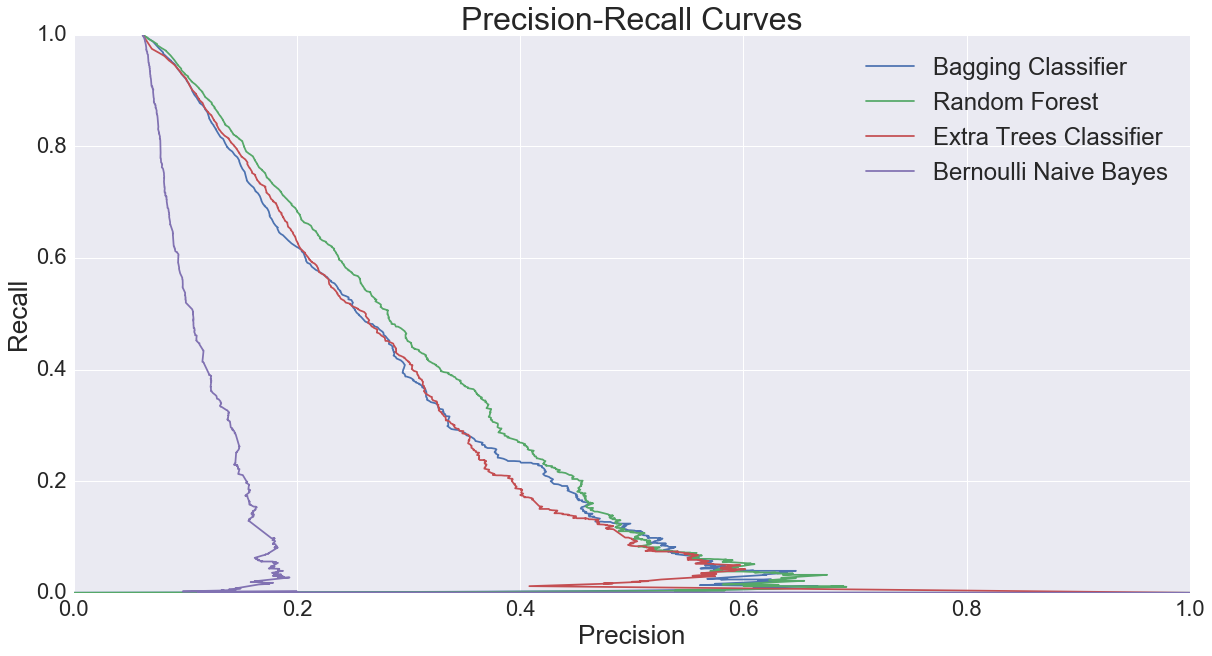

In [7]:
f = clean.columns[:-2].tolist() #Set list of features
l = clean.columns[-1] #set label

plt.figure(figsize=(20,10))
plot_PR_curve_noadj("Bagging Classifier", BaggingClassifier(n_estimators=500), f, l)
plot_PR_curve_noadj("Random Forest", RandomForestClassifier(n_estimators=500), f, l)
plot_PR_curve_noadj("Extra Trees Classifier", ExtraTreesClassifier(n_estimators=500), f, l)
plot_PR_curve_noadj("Bernoulli Naive Bayes", BernoulliNB(), f, l)

plt.legend(loc="best", fontsize=24)
plt.xlabel("Precision", fontsize=26)
plt.ylabel("Recall", fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Precision-Recall Curves", fontsize=32)
plt.savefig("graphics/Precision-Recall-Overall.png")

#### Evaluate precision-recall tradeoff with 1:1 downsampling

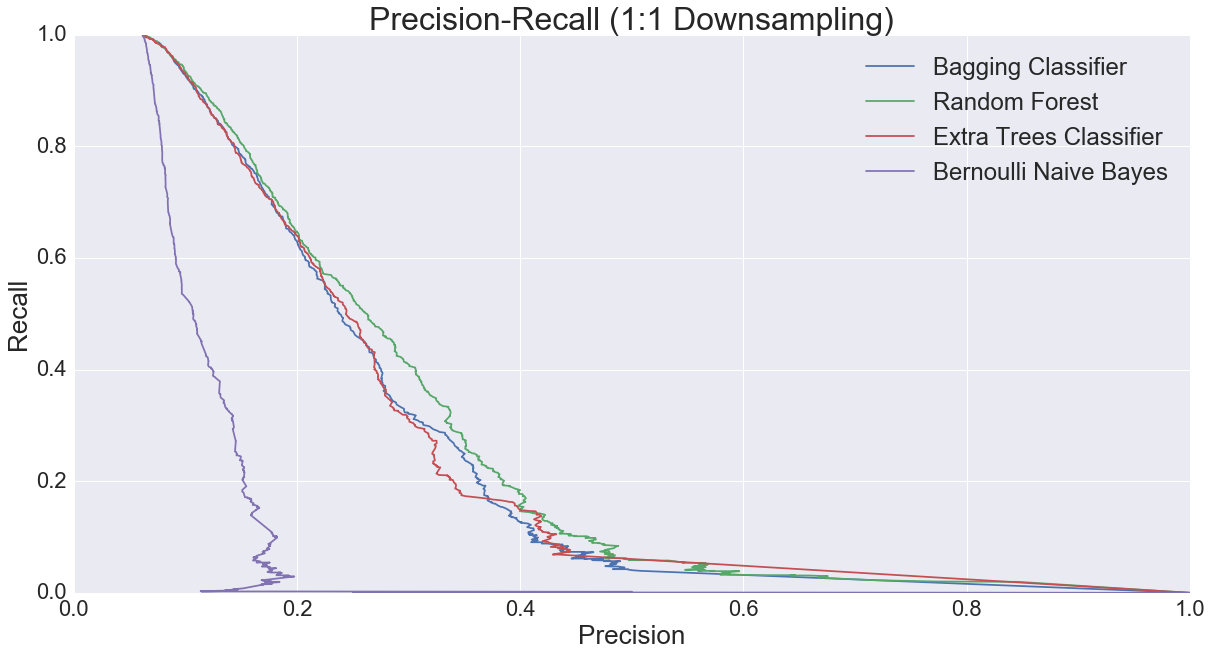

In [8]:
plt.figure(figsize=(20,10))
plot_PR_curve("Bagging Classifier", BaggingClassifier(n_estimators=500), 1.0, False, f, l)
plot_PR_curve("Random Forest", RandomForestClassifier(n_estimators=500), 1.0, False, f, l)
plot_PR_curve("Extra Trees Classifier", ExtraTreesClassifier(n_estimators=500), 1.0, False, f, l)
plot_PR_curve("Bernoulli Naive Bayes", BernoulliNB(), 1.0, False, f, l)

plt.legend(loc="best", fontsize=24)
plt.xlabel("Precision", fontsize=26)
plt.ylabel("Recall", fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Precision-Recall (1:1 Downsampling)", fontsize=32)
plt.savefig("graphics/precision-recall-1to1downsample.png")

#### Evaluate random forest (best performing classifier) with various upsampling/ downsampling ratios

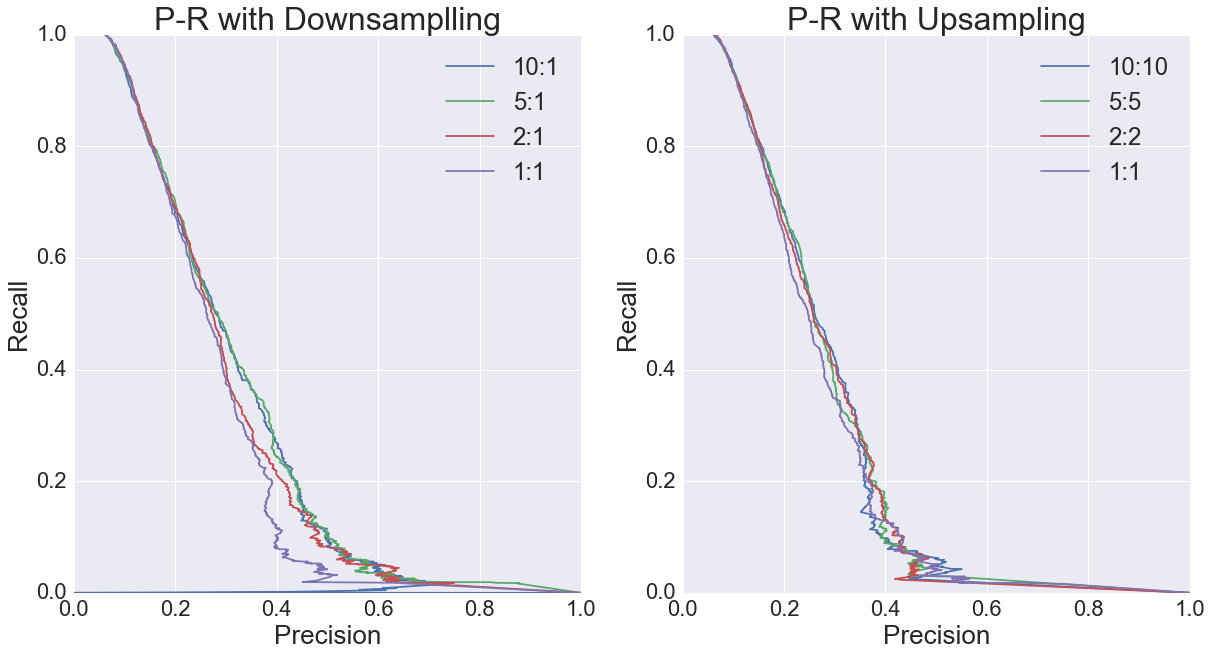

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plot_PR_curve("10:1", RandomForestClassifier(n_estimators=500), 10.0, False, f, l)
plot_PR_curve("5:1", RandomForestClassifier(n_estimators=500), 5.0, False, f, l)
plot_PR_curve("2:1", RandomForestClassifier(n_estimators=500), 2.0, False, f, l)
plot_PR_curve("1:1", RandomForestClassifier(n_estimators=500), 1.0, False, f, l)

plt.legend(loc="best", fontsize=24)
plt.xlabel("Precision", fontsize=26)
plt.ylabel("Recall", fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("P-R with Downsamplling", fontsize=32)

plt.subplot(1,2,2)
plot_PR_curve("10:10", RandomForestClassifier(n_estimators=500), 10.0, True, f, l)
plot_PR_curve("5:5", RandomForestClassifier(n_estimators=500), 5.0, True, f, l)
plot_PR_curve("2:2", RandomForestClassifier(n_estimators=500), 2.0, True, f, l)
plot_PR_curve("1:1", RandomForestClassifier(n_estimators=500), 1.0, True, f, l)

plt.legend(loc="best", fontsize=24)
plt.xlabel("Precision", fontsize=26)
plt.ylabel("Recall", fontsize=26)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("P-R with Upsampling", fontsize=32)

plt.savefig("graphics/precision-recall-up-down-sample.png")